# 모든 의약품 처방 정보 추출, 그룹화 시켜서 합병증 관련 알아보기

## 우선 2021년

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [33]:
# 세 개의 CSV 파일 경로 리스트 생성
csv_files = ['D:/소셜네트워크과학/국민건강보험공단_의약품처방정보_01_20211231.csv', 'D:/소셜네트워크과학/국민건강보험공단_의약품처방정보_02_20211231.csv', 'D:/소셜네트워크과학/국민건강보험공단_의약품처방정보_03_20211231.csv']

# 빈 리스트 생성
df_list = []

# 각 CSV 파일을 읽어 리스트에 추가
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# 모든 데이터프레임을 하나로 합치기
df = pd.concat(df_list, ignore_index=True)
df

,STND_Y,IDV_ID,KEY_SEQ,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,GNL_NM_CD,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT
0,2021,628074,9261,1,2,13,41,2021-09-13,347701ACH,1.0000,1,3,521.0,1563,2022-08-11
1,2021,730013,13348,1,2,13,41,2021-02-17,493801ATB,1.0000,1,3,534.0,1602,2022-08-11
2,2021,97734,16827,1,2,13,41,2021-06-10,374602ATB,1.0000,1,3,469.0,1407,2022-08-11
3,2021,818851,20079,1,2,13,41,2021-09-15,367201ATB,1.0000,1,3,764.0,2292,2022-08-11
4,2021,835362,26258,1,2,13,41,2021-07-17,111501ATB,1.0000,1,30,644.0,19320,2022-08-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32053866,2021,678592,12265562,1,1,12,48,2021-04-11,463601ATB,0.3335,2,10,210.0,1401,2022-08-11
32053867,2021,284314,12266745,3,1,1,41,2021-06-06,163104ATB,0.2333,3,6,126.0,529,2022-08-11
32053868,2021,284314,12266745,1,1,1,41,2021-06-06,126031AGN,0.5000,3,6,762.0,6858,2022-08-11
32053869,2021,660930,12266847,2,1,14,41,2021-09-05,567401ATB,0.5000,1,28,311.0,4354,2022-08-11


In [34]:
df.to_csv('2021_drugs.csv', index=False, encoding='cp949')

In [3]:
df.rename(columns={'IDV_ID': 'uid',  # user id
                   'KEY_SEQ': 'pid',  # prescription id
                   'GNL_NM_CD': 'mi_code'}, inplace=True)

In [4]:
drug_mapping = pd.read_csv("D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis/data/mapping.csv")
drug_mapping

,주성분코드_9,ATC코드,주성분명,주성분코드_5
0,130830ASY,N05CC01,chloral hydrate,1308A
1,130832ASY,N05CC01,chloral hydrate,1308A
2,130833ASY,N05CC01,chloral hydrate,1308A
3,149203ATB,N05CM,Other hypnotics and sedatives,1492A
4,149204ATB,N05CM,Other hypnotics and sedatives,1492A
...,...,...,...,...
6208,158212CPL,N02AB03,fentanyl,1582C
6209,158213CPL,N02AB03,fentanyl,1582C
6210,630905CSI,N02AB03,fentanyl,6309C
6211,630906CSI,N02AB03,fentanyl,6309C


In [5]:
# drug_mapping과 df를 병합하여 ATC코드 추가
df = pd.merge(df, 
             drug_mapping[['주성분코드_9', 'ATC코드']], 
             left_on='mi_code',
             right_on='주성분코드_9',
             how='left')

# 중복 열 제거 (주성분코드_9 열은 필요없으므로 삭제)
df = df.drop('주성분코드_9', axis=1)
df

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드
0,2021,628074,9261,1,2,13,41,2021-09-13,347701ACH,1.0000,1,3,521.0,1563,2022-08-11,M01AH01
1,2021,730013,13348,1,2,13,41,2021-02-17,493801ATB,1.0000,1,3,534.0,1602,2022-08-11,G04BD08
2,2021,97734,16827,1,2,13,41,2021-06-10,374602ATB,1.0000,1,3,469.0,1407,2022-08-11,R03DC03
3,2021,818851,20079,1,2,13,41,2021-09-15,367201ATB,1.0000,1,3,764.0,2292,2022-08-11,A02BC05
4,2021,835362,26258,1,2,13,41,2021-07-17,111501ATB,1.0000,1,30,644.0,19320,2022-08-11,C10AA05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36422034,2021,678592,12265562,1,1,12,48,2021-04-11,463601ATB,0.3335,2,10,210.0,1401,2022-08-11,R06AE09
36422035,2021,284314,12266745,3,1,1,41,2021-06-06,163104ATB,0.2333,3,6,126.0,529,2022-08-11,R03CC15
36422036,2021,284314,12266745,1,1,1,41,2021-06-06,126031AGN,0.5000,3,6,762.0,6858,2022-08-11,J01DD16
36422037,2021,660930,12266847,2,1,14,41,2021-09-05,567401ATB,0.5000,1,28,311.0,4354,2022-08-11,M04AA03


In [6]:
df[df['ATC코드'] == 'R03DC03']

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드
2,2021,97734,16827,1,2,13,41,2021-06-10,374602ATB,1.0000,1,3,469.0,1407,2022-08-11,R03DC03
92,2021,271936,359212,1,2,13,41,2021-02-18,374602ATB,1.0000,1,3,774.0,2322,2022-08-11,R03DC03
138,2021,271071,548289,1,2,13,41,2021-07-19,374602ATB,1.0000,1,3,765.0,2295,2022-08-11,R03DC03
172,2021,225320,651413,1,2,13,41,2021-12-13,374602ATB,1.0000,1,3,765.0,2295,2022-08-11,R03DC03
173,2021,271936,656486,1,2,13,41,2021-03-05,374602ATB,1.0000,1,3,774.0,2322,2022-08-11,R03DC03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36421399,2021,176695,9409510,4,1,1,41,2021-05-05,374603AGN,0.3333,3,6,695.0,4170,2022-08-11,R03DC03
36421411,2021,27730,9447033,4,2,2,26,2021-01-01,374603AGN,0.5000,2,7,693.0,4851,2022-08-11,R03DC03
36421529,2021,640737,10028752,5,1,2,41,2021-10-24,374603AGN,0.3333,3,7,695.0,4865,2022-08-11,R03DC03
36421698,2021,531605,10723083,3,1,2,11,2021-09-19,374603AGN,0.3333,3,7,695.0,4865,2022-08-11,R03DC03


In [7]:
# ATC코드 열의 문자열 길이 계산
atc_lengths = drug_mapping['ATC코드'].apply(len)

# 최소 길이 찾기
min_length = atc_lengths.min()

# 최소 길이를 가진 값들 찾기
min_length_values = drug_mapping[drug_mapping['ATC코드'].str.len() == min_length]

# 결과 출력
print(f"최소 길이: {min_length}")
print("\n최소 길이를 가진 값들:")
print(min_length_values['ATC코드'].value_counts())

최소 길이: 3

최소 길이를 가진 값들:
ATC코드
D03    5
R05    2
B02    2
R07    1
Name: count, dtype: int64


In [8]:
# atc 코드 앞자리 3자리로만 매핑
df['ATC코드'] = df['ATC코드'].str[:3]
df.head()

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드
0,2021,628074,9261,1,2,13,41,2021-09-13,347701ACH,1.0,1,3,521.0,1563,2022-08-11,M01
1,2021,730013,13348,1,2,13,41,2021-02-17,493801ATB,1.0,1,3,534.0,1602,2022-08-11,G04
2,2021,97734,16827,1,2,13,41,2021-06-10,374602ATB,1.0,1,3,469.0,1407,2022-08-11,R03
3,2021,818851,20079,1,2,13,41,2021-09-15,367201ATB,1.0,1,3,764.0,2292,2022-08-11,A02
4,2021,835362,26258,1,2,13,41,2021-07-17,111501ATB,1.0,1,30,644.0,19320,2022-08-11,C10


## EDA

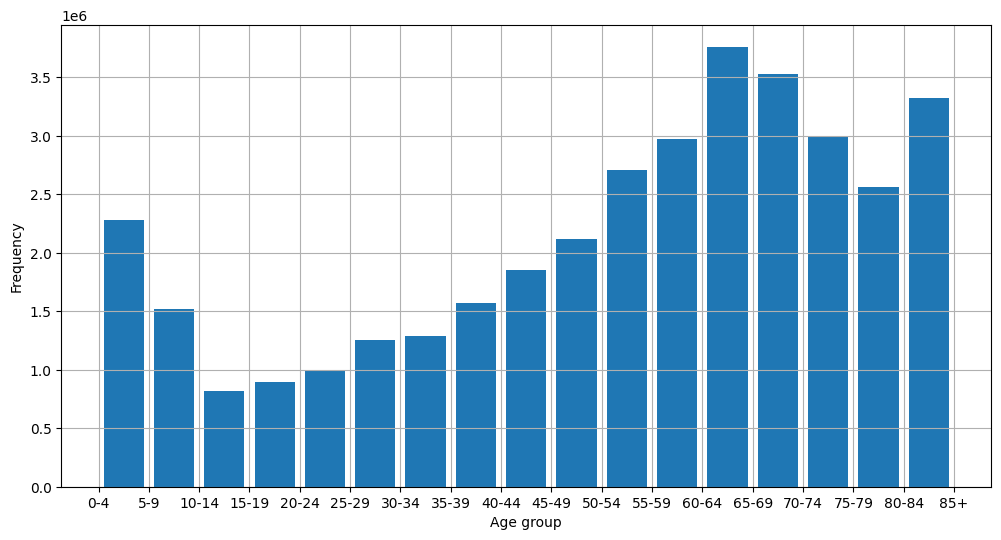

In [9]:
# 연령대코드(5세단위)를 그래프로 그립니다.
figure = plt.figure(figsize=(12, 6))
df['AGE_GROUP'].hist(bins=range(1, 19), rwidth=0.8)
plt.xlabel('Age group')
plt.ylabel('Frequency')
plt.xticks(range(1, 19), ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+'])
plt.show()

### 연령대 6&7(25~34)만 따로 확인하기

In [10]:
df_economic = df[(df['AGE_GROUP']==6) | (df['AGE_GROUP']==7)]
df_economic

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드
29592,2021,351711,170250,1,2,7,41,2021-03-30,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01
29854,2021,889888,1277762,1,2,7,41,2021-09-14,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01
29999,2021,115866,1789035,1,2,7,41,2021-10-14,111001ACE,1.0,1,30,77.0,2310,2022-08-11,B01
30087,2021,889888,2181490,1,2,7,41,2021-10-13,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01
30456,2021,539865,3576249,1,2,6,41,2021-08-07,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36421962,2021,199076,11917936,1,1,7,41,2021-12-25,458402ATB,2.0,2,2,163.0,1304,2022-08-11,M01
36421969,2021,611849,11950234,3,2,6,11,2021-02-13,159903ACH,3.0,1,1,1726.0,5178,2022-08-11,J02
36421976,2021,924046,11971673,1,2,7,11,2021-11-07,193302ATB,1.5,1,7,97.0,1019,2022-08-11,H02
36421981,2021,121741,11986158,3,1,7,49,2021-12-19,427800ACH,2.0,1,26,371.0,19292,2022-08-11,A05


## Adjacency Matrix

In [11]:
from itertools import combinations
from collections import Counter

In [12]:
def process_patient_data(patient_groups):
    # 페어 카운트를 저장할 Counter 초기화
    pair_counts = Counter()

    for patient_id, group in patient_groups:
        # 해당 환자의 모든 처방 가져오기
        prescriptions = group.groupby('pid')['ATC코드'].apply(list)

        # 해당 환자의 유니크 약물 주성분 페어와 자기 자신 루프를 저장할 집합
        patient_pairs = set()
        patient_self_loops = set()

        # 해당 환자에게 처방된 모든 유니크 약물 주성분 페어와 자기 자신 루프 수집
        for meds in prescriptions:
            # 처방 내 각 약물 주성분의 발생 횟수 계산
            med_counts = Counter(meds)

            # 한 번 이상 나타나는 약물 주성분 식별 (self-loop)
            for med, count in med_counts.items():
                if count > 1:
                    patient_self_loops.add(med)

            # 페어 조합을 위한 처방 내 유니크 약물 주성분 가져오기
            unique_meds_in_prescription = set(meds)
            pairs = combinations(unique_meds_in_prescription, 2)
            patient_pairs.update(pairs)

        # 해당 환자의 유니크 페어를 글로벌 페어 카운트에 업데이트
        pair_counts.update(patient_pairs)

        # 자기 자신 루프를 글로벌 페어 카운트에 업데이트
        for med in patient_self_loops:
            pair_counts[(med, med)] += 1

    return pair_counts

In [13]:
def build_adjacency_matrix(pair_counts, med_to_index):
    # 페어 카운트를 사용하여 인접 행렬 채우기
    adj_matrix = np.zeros((len(med_to_index), len(med_to_index)))

    for (med1, med2), count in pair_counts.items():
        idx1 = med_to_index[med1]
        idx2 = med_to_index[med2]
        adj_matrix[idx1][idx2] = count
        if med1 != med2:
            adj_matrix[idx2][idx1] = count  # 대칭 페어의 경우
        else:
            adj_matrix[idx1][idx2] = count  # 자기 자신 루프 (대각선 요소)

    return adj_matrix

In [14]:
# 약품 코드를 인덱스로 매핑
unique_meds = df_economic["ATC코드"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = df_economic.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 인접 행렬을 데이터프레임으로 변환
df_adjacency_matrix_6_7 = pd.DataFrame(adj_matrix, index=unique_meds, columns=unique_meds)

In [15]:
df_adjacency_matrix_6_7.iloc[:5, :5]

,B01,A02,N05,N06,G04
B01,61.0,5.0,71.0,71.0,3.0
A02,5.0,57174.0,3210.0,187.0,4.0
N05,71.0,3210.0,1628.0,419.0,57.0
N06,71.0,187.0,419.0,1021.0,37.0
G04,3.0,4.0,57.0,37.0,688.0


## 네트워크 시각화

In [16]:
# adjacency matrix를 networkx 그래프로 변환합니다.
G = nx.from_pandas_adjacency(df_adjacency_matrix_6_7)

In [17]:
# 각 노드에 ATC코드 속성 추가
for node in G.nodes():
    G.nodes[node]['ATC코드'] = node  # 노드 자체가 ATC코드입니다

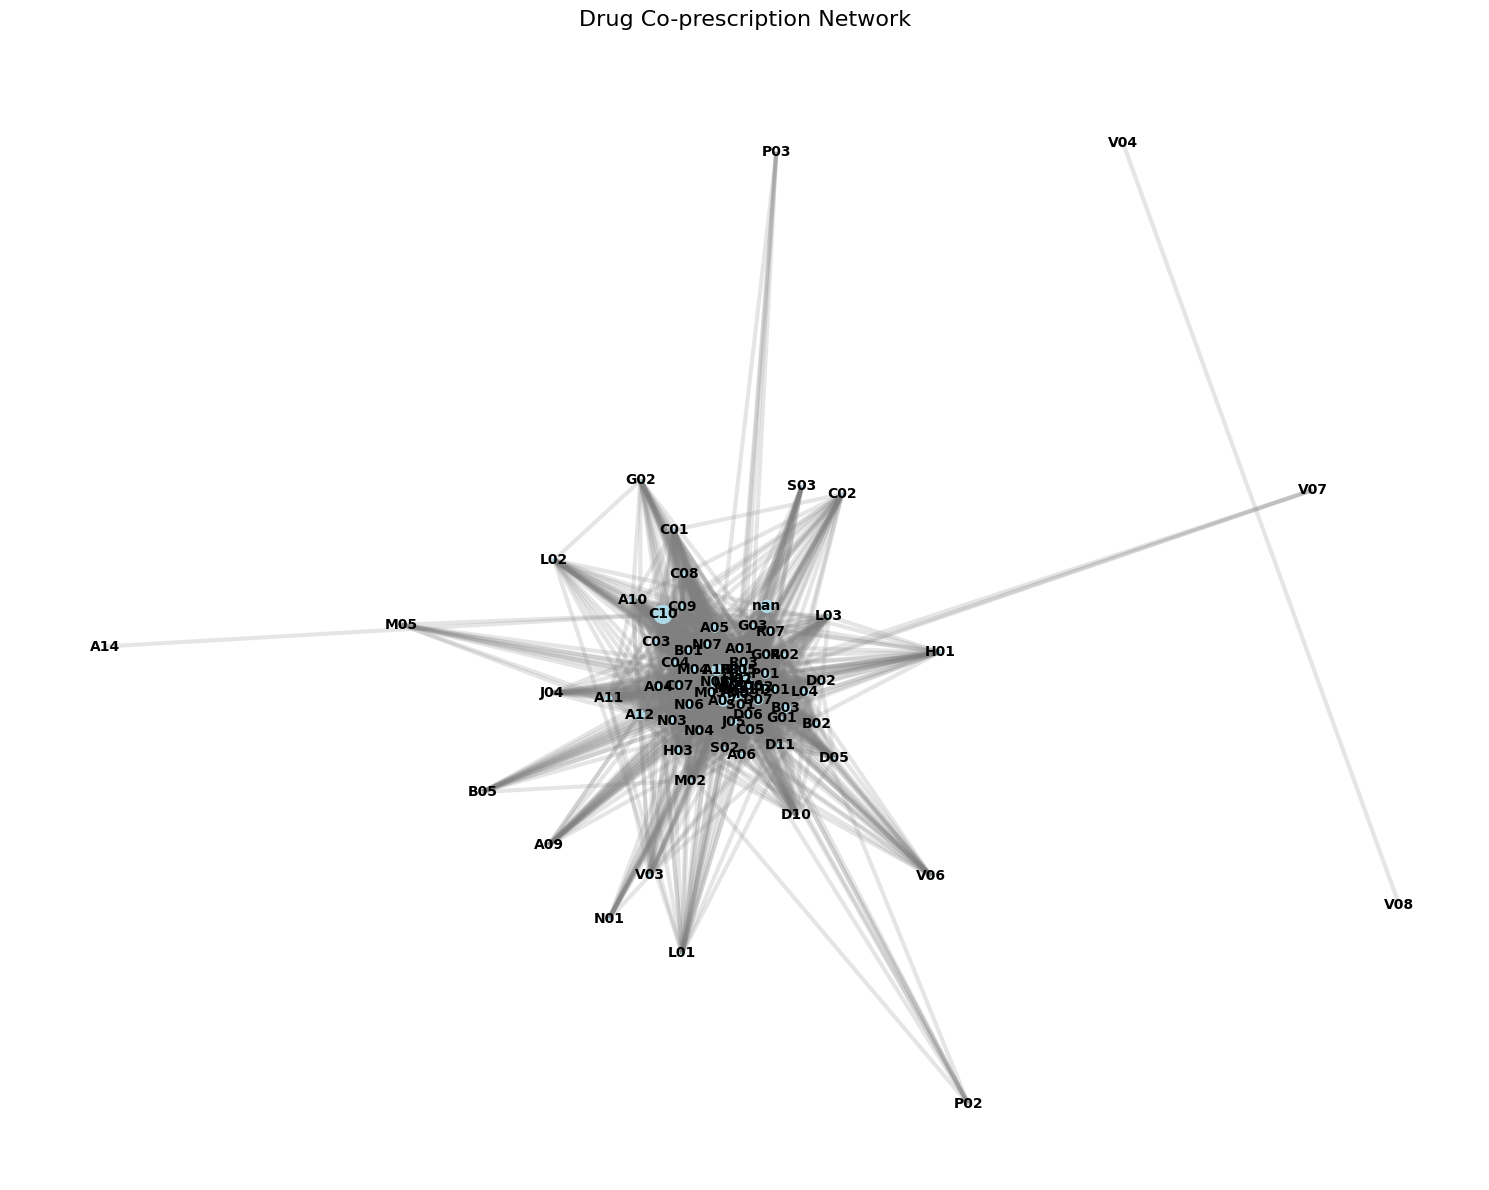

In [19]:


# self-loop 제거
G.remove_edges_from(nx.selfloop_edges(G))

# 시각화 설정
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=42, k=1.0)

# betweenness centrality 계산
betweenness_centrality = nx.betweenness_centrality(G)
node_size = [v * 5000 for v in betweenness_centrality.values()]

# 노드 그리기
nx.draw_networkx_nodes(G, pos, 
                      node_size=node_size,
                      node_color='lightblue',
                      linewidths=1)

# 엣지 그리기
max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
for u, v, d in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, 
                          edgelist=[(u, v)], 
                          alpha=min(d['weight'] / max_weight + 0.2, 1),
                          width=3,
                          edge_color='gray')

# 레이블 추가
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, 
                       font_size=10,
                       font_weight='bold')

plt.title('Drug Co-prescription Network', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

### 엣지 가중치 정보 확인하기

In [20]:
# 인접행렬의 모든 값을 1차원으로 변환하여 가중치 분포 확인
weights = df_adjacency_matrix_6_7.values.flatten()

# 0이 아닌 값들만 선택 (실제 엣지가 있는 경우만)
non_zero_weights = weights[weights != 0]

# 가중치 통계 확인
pd.Series(non_zero_weights).describe()

count     3763.000000
mean       352.550890
std       2277.006383
min          1.000000
25%          2.000000
50%          6.000000
75%         35.000000
max      57174.000000
dtype: float64

### 가중치 2 이하인 엣지 삭제하고 다시 시각화

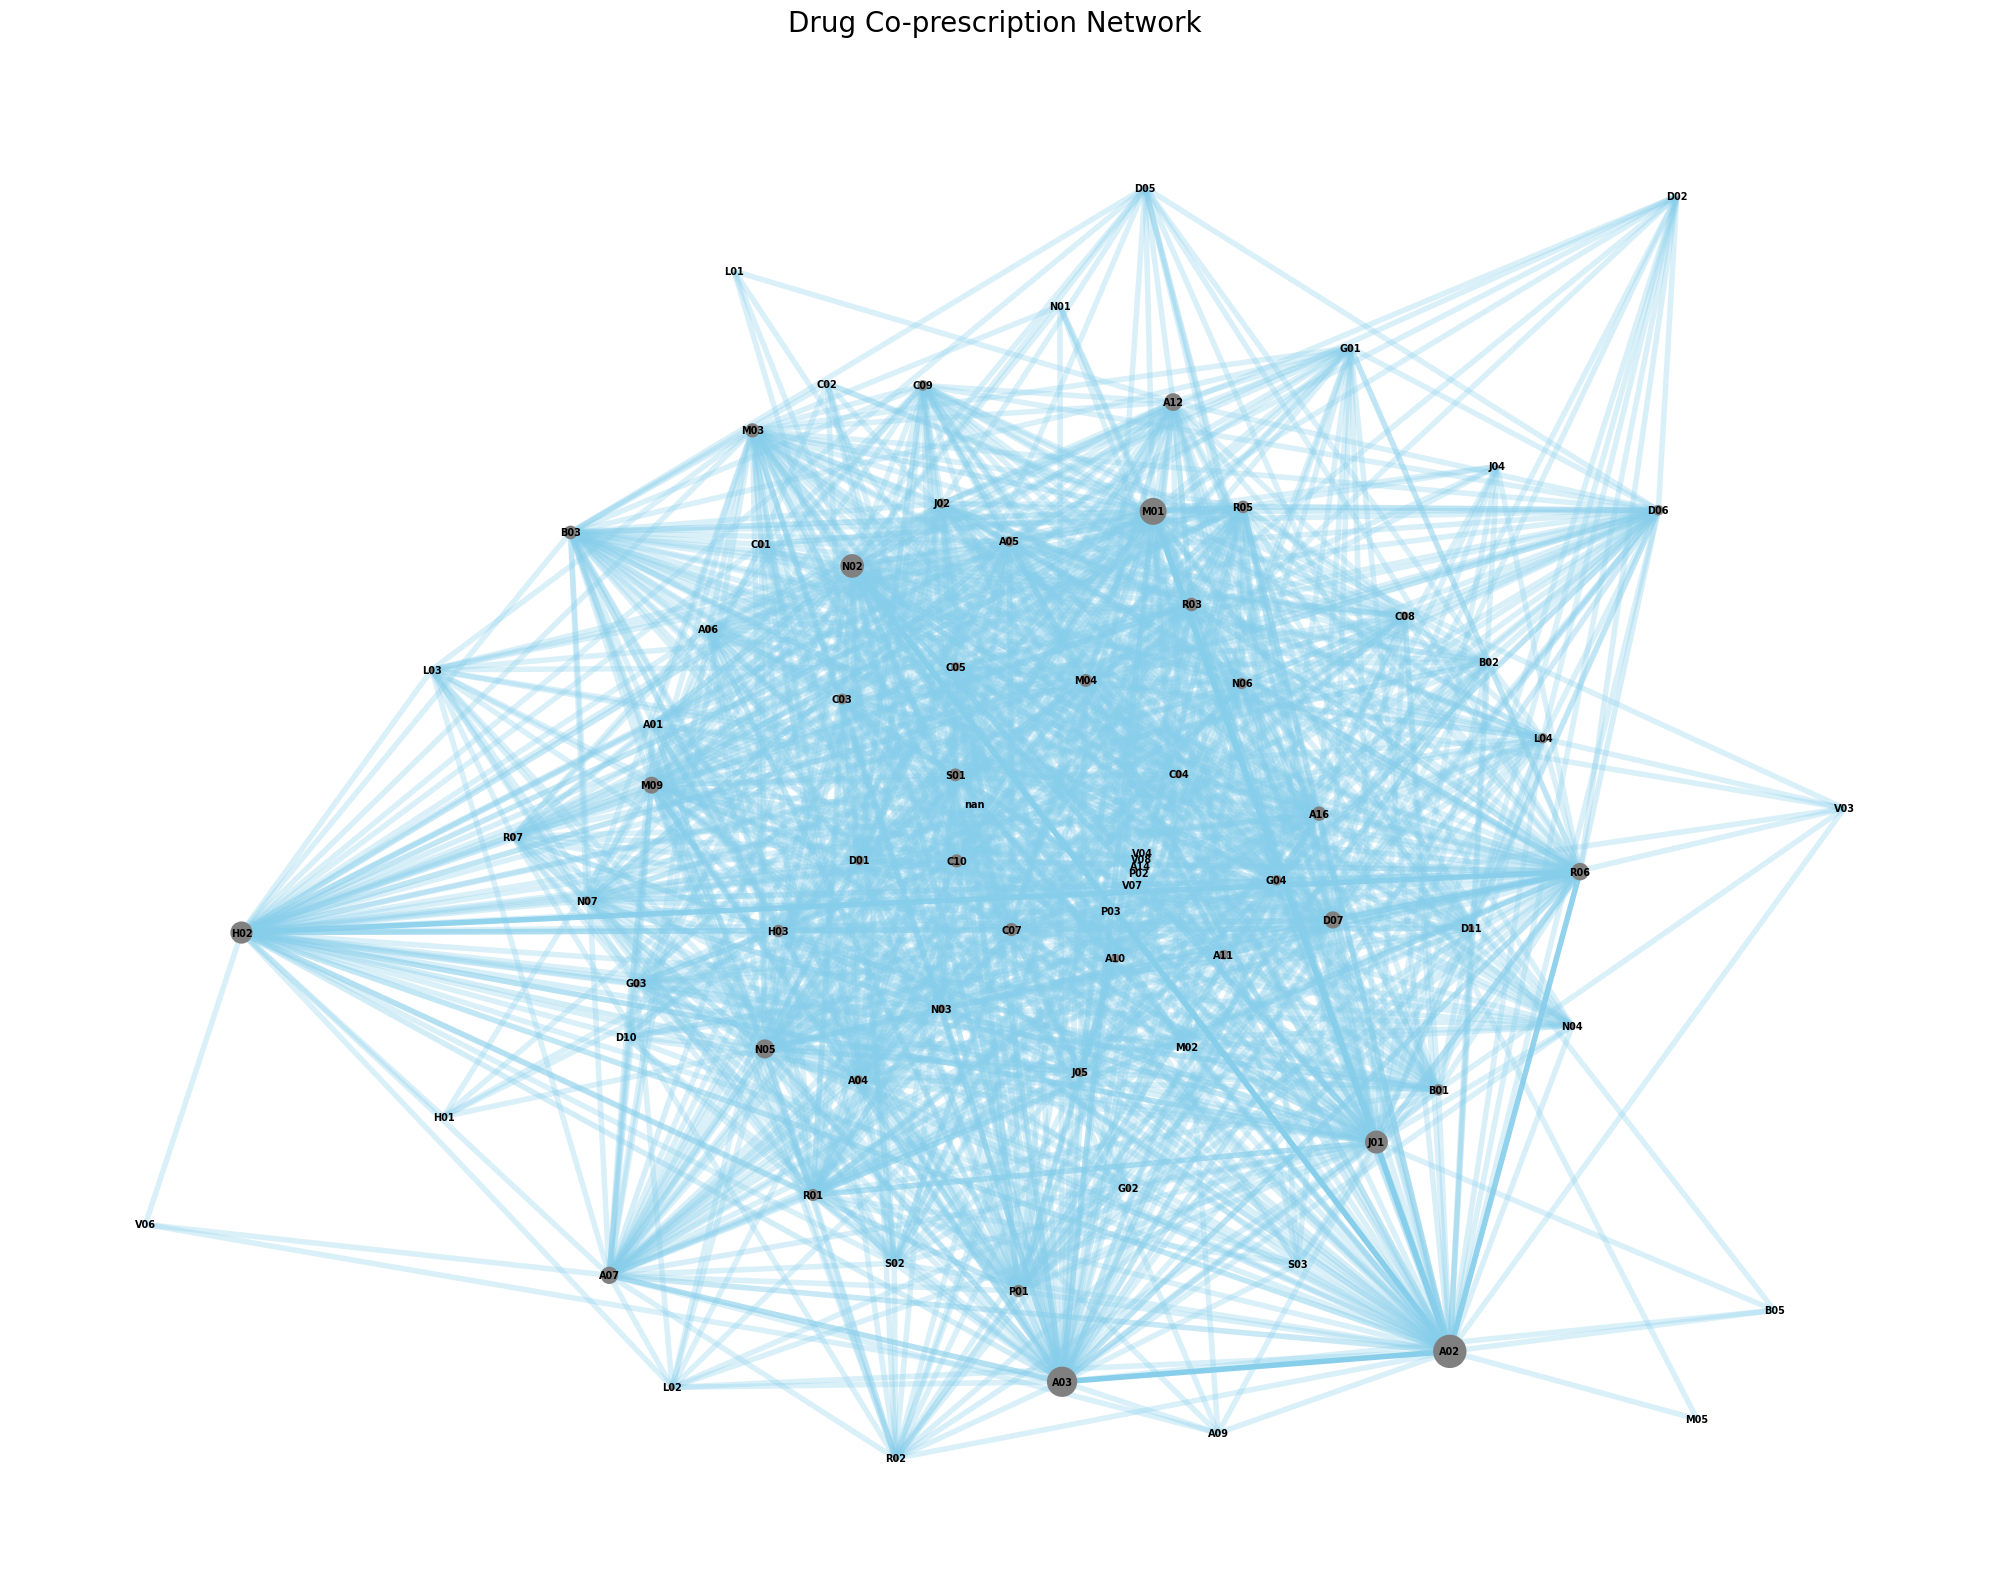

In [28]:
# nan 값과 가중치가 2 이하인 엣지 제거
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) 
                   if pd.isna(u) or pd.isna(v) or d['weight'] <= 2]
G.remove_edges_from(edges_to_remove)
G.remove_edges_from(nx.selfloop_edges(G))

# 시각화 설정
plt.figure(figsize=(20, 16))  # 그래프 크기 증가
pos = nx.kamada_kawai_layout(G)  # k값 증가로 노드 간격 더 넓게

# betweenness centrality 계산
betweenness_centrality = nx.betweenness_centrality(G)
node_size = [v * 8000 for v in betweenness_centrality.values()]  # 노드 크기 증가

# 노드 그리기
nx.draw_networkx_nodes(G, pos, 
                      node_size=node_size,
                      node_color='gray',  # 더 밝은 색상
                      linewidths=2)          # 테두리 두께 증가

# 엣지 그리기
max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
for u, v, d in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, 
                          edgelist=[(u, v)], 
                          alpha=min(d['weight'] / max_weight + 0.3, 1),  # 최소 투명도 증가
                          width=4,           # 엣지 두께 증가
                          edge_color='skyblue') # 엣지 색상 변경

# 레이블 추가
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, 
                       font_size=7,        # 폰트 크기 증가
                       font_weight='bold',
                       font_color='black')   # 폰트 색상 변경

plt.title('Drug Co-prescription Network', fontsize=20, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

### 외부 툴에서 시각화 위한 파일

In [30]:
# Gephi용 GraphML 파일로 저장
nx.write_graphml(G, '2021_drug_coprescription_network.graphml')

# Pajek용 .net 파일로 저장
nx.write_pajek(G, '2021_drug_coprescription_network.net')